<a href="https://colab.research.google.com/github/JEunJin/web1/blob/master/WeatherForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#필요한 라이브러리 호출 및 날씨 데이터 셋 다운로드
#사용되는 데이터 셋은 독일의 Max Planck Institute for Biogeochemistry에서 관측한 날씨 데이터 셋으로
#2003년 이후 10분 간격으로 관측된 온도, 대기압, 습도와 같은 14종류의 다양한 관측치를 포함 (실습에는 2009~2016년 데이터 사용)
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)
csv_path, _ = os.path.splitext(zip_path)

13582336/13568290 [==============================] - 1s 0us/step


In [ ]:
#데이터셋 확인
df = pd.read_csv(csv_path)
print(df.head())
print(df.columns)

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [ ]:
#특정한 시간의 데이터를 얻기 위해 다음과 같은 함수 사용
#history_size : 과거 데이터의 크기
#target_size : 모델이 얼마 동안의 미래를 예측하는지 의미
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
      end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
      indices = range(i - history_size, i)
      # Reshape data from (history_size,) to (history_size, 1)
      data.append(np.reshape(dataset[indices], (history_size, 1)))
      labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [ ]:
#300,000개 행의 데이터를 훈련에 사용하고, 이후의 데이터는 검증에 사용
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

# **↑ 여기까지 날씨 데이터셋 ↑**

In [ ]:
#온도 데이터 추출
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64


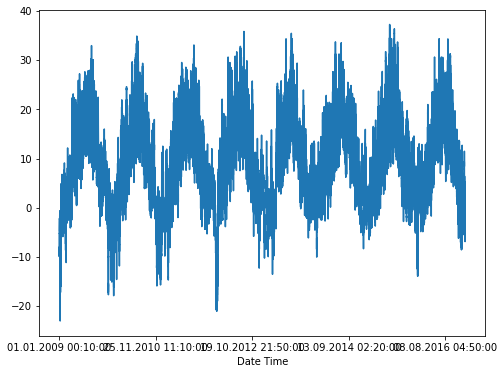

In [ ]:
#온도 데이터 시각화
uni_data.plot(subplots=True)
plt.show()

In [ ]:
#표준화(Standardization) : 세 가지 종류의 데이터에 대해서 평균을 빼고 표준편차로 나누어줌
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

print(uni_data)

[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


In [ ]:
#단변량 모델 데이터 생성
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [ ]:
#단변량 모델 데이터를 플롯하기 위한 함수 생성
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

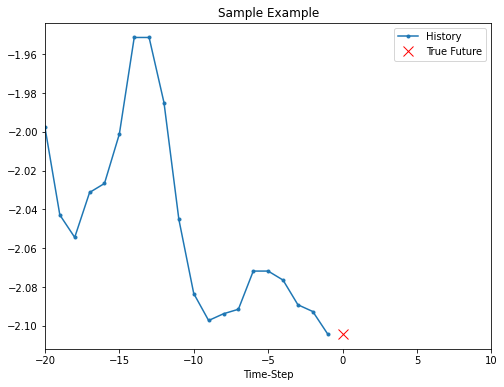

In [ ]:
#플롯 그래프 출력
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

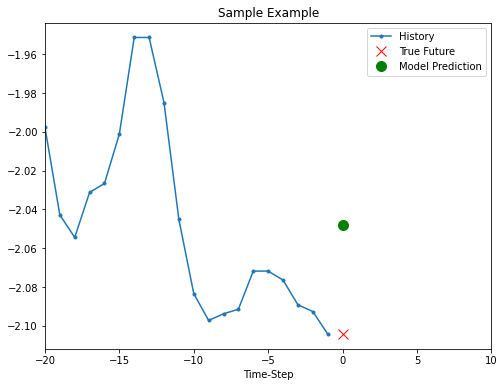

In [ ]:
#첫 번째 예측
def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

# **↑ 여기까지 단변량 시계열 데이터 예측 ↑**

Epoch 1/10
200/200 [==============================] - 7s 14ms/step - loss: 0.5302 - val_loss: 0.1227
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1015 - val_loss: 0.0322
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0425 - val_loss: 0.0259
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0386 - val_loss: 0.0227
Epoch 5/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0258 - val_loss: 0.0214
Epoch 6/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0283 - val_loss: 0.0201
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0256 - val_loss: 0.0192
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0242 - val_loss: 0.0180
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0237 - val_loss: 0.0170
Epoch 10/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0214 - val_lo

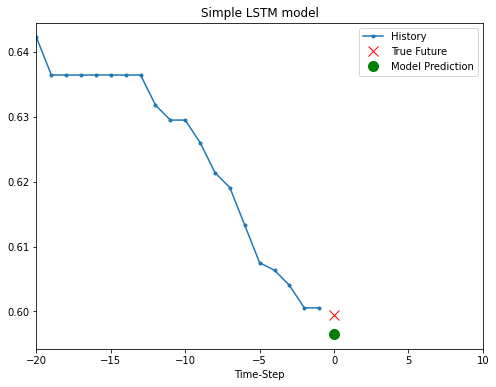

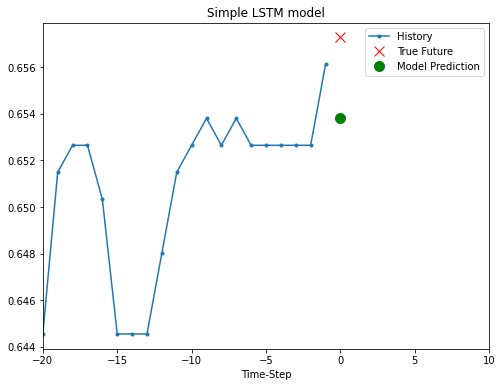

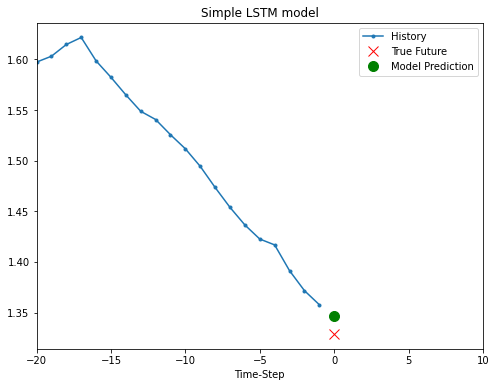

In [ ]:
#데이터셋 shuffle, batch, cache 작업
#from_tensor_slice는 주어진 텐서들을 첫번째 차원을 따라 슬라이스 함.
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

#LSTM 모델 생성
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

#LSRM 모델 훈련
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

#생성된 LSTM모델을 통한 예측
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# **↑ 여기까지 순환신경망 시계열 데이터 예측 ↑**




In [ ]:
#데이터 프레임(df)에서 세 개의 데이터 열을 가져옴(기압, 온도, 공기밀도)
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
print(features.head())

                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
01.01.2009 00:10:00    996.52     -8.02       1307.75
01.01.2009 00:20:00    996.57     -8.41       1309.80
01.01.2009 00:30:00    996.53     -8.51       1310.24
01.01.2009 00:40:00    996.51     -8.31       1309.19
01.01.2009 00:50:00    996.51     -8.27       1309.00


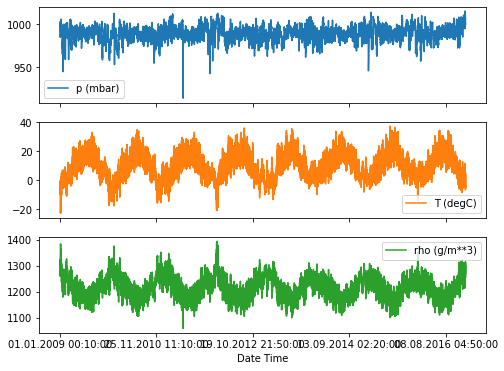

In [ ]:
#가져온 세 개의 데이터 열을 그래프로 출력
features.plot(subplots=True)
plt.show()

In [ ]:
#표준화(Standardization) : 세 가지 종류의 데이터에 대해서 평균을 빼고 표준편차로 나누어줌
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


In [ ]:
#한 스텝 예측
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [ ]:
#past_history : 지난 5일간의 데이터
#future_target : 72시간 스텝 이후(12시간)를 예측할 것을 의미
#STEP : 샘플링 간격 
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


(256, 1)
Epoch 1/10
200/200 [==============================] - 24s 108ms/step - loss: 0.3118 - val_loss: 0.2599
Epoch 2/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2623 - val_loss: 0.2516
Epoch 3/10
200/200 [==============================] - 21s 106ms/step - loss: 0.2622 - val_loss: 0.2435
Epoch 4/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2568 - val_loss: 0.2423
Epoch 5/10
200/200 [==============================] - 21s 104ms/step - loss: 0.2289 - val_loss: 0.2365
Epoch 6/10
200/200 [==============================] - 21s 105ms/step - loss: 0.2424 - val_loss: 0.2615
Epoch 7/10
200/200 [==============================] - 24s 118ms/step - loss: 0.2416 - val_loss: 0.2589
Epoch 8/10
200/200 [==============================] - 24s 118ms/step - loss: 0.2406 - val_loss: 0.2454
Epoch 9/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2457 - val_loss: 0.2638
Epoch 10/10
200/200 [==============================] - 22s 108ms

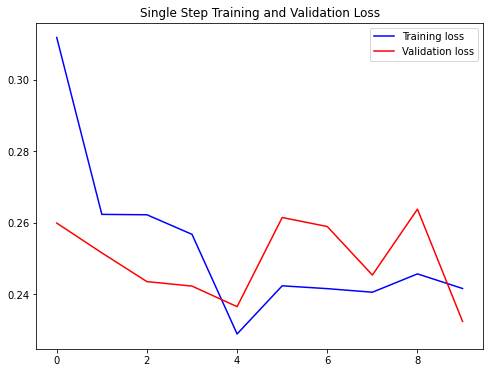

In [ ]:
#다변량 시계열 데이터의 한 스텝 예측을 위한 인공신경망 모델 구성 및 10회 epoch 학습 진행

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

#학습 과정을 그래프로 표현
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

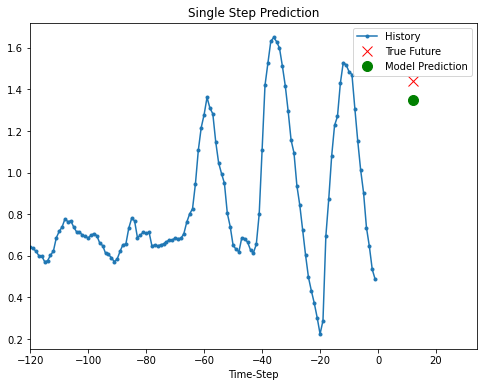

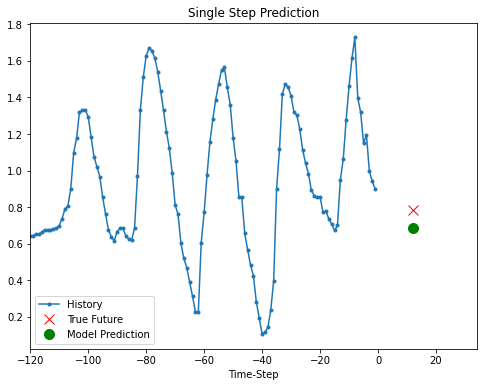

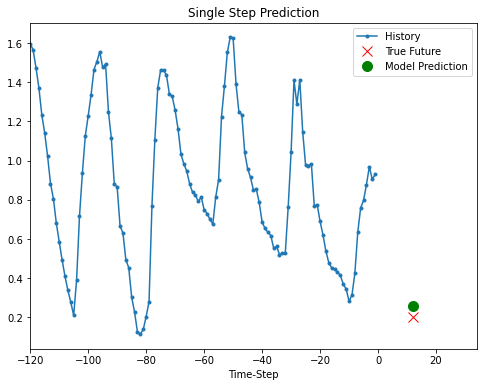

In [ ]:
#학습된 모델을 활용하여 한 스텝 예측 진행
#지난 5일간 매 시간 측정된 세가지 종류의 각 120개의 데이터가 주어지고, 12시간 후의 온도를 예측
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [ ]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


# **↑ 여기까지 다변량 시계열 데이터 예측 ↑**